In [6]:
!pip install yfinance pandas matplotlib numpy prophet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
from scipy.stats import linregress

In [7]:
#Download Historical Stock Prices
stock = yf.Ticker("AAPL")
hist = stock.history(period="1y")
hist.reset_index(inplace=True)
hist.head()


Date        Open        High         Low       Close  \
0 2024-07-15 00:00:00-04:00  235.379203  236.125712  232.004984  233.308884   
1 2024-07-16 00:00:00-04:00  233.906084  235.170176  231.248514  233.726929   
2 2024-07-17 00:00:00-04:00  228.381929  230.382583  225.585012  227.814590   
3 2024-07-18 00:00:00-04:00  229.208055  229.367314  221.235347  223.136444   
4 2024-07-19 00:00:00-04:00  223.773490  225.744269  222.240650  223.265854   

     Volume  Dividends  Stock Splits  
0  62631300        0.0           0.0  
1  43234300        0.0           0.0  
2  57345900        0.0           0.0  
3  66034600        0.0           0.0  
4  49151500        0.0           0.0

In [8]:
income = stock.financials
balance = stock.balance_sheet
cashflow = stock.cashflow

#Save to CSV for Excel work
income.to_csv("income_statement.csv")
balance.to_csv("balance_sheet.csv")
cashflow.to_csv("cashflow_statement.csv")


In [9]:
# # from google.colab import files
# files.download("income_statement.csv")
# files.download("balance_sheet.csv")
# files.download("cashflow_statement.csv")


In [11]:
# Load the stock
stock = yf.Ticker("AAPL")

# Get all dividend history
dividends = stock.get_dividends()

# Convert to DataFrame and reset index
dividends_df = dividends.reset_index()
dividends_df.columns = ['Date', 'Dividend']

# Filter by date range
start_date = '2024-04-01'
end_date = '2025-03-31'
dividends_df_filtered = dividends_df[(dividends_df['Date'] >= start_date) & (dividends_df['Date'] <= end_date)]


# Save as CSV
dividends_df_filtered.to_csv("dividend_history.csv", index=False)


## Technical Analysis

In [13]:
#Show Line Chart for Past 1 Year
plt.figure(figsize=(12,6))
plt.plot(hist['Date'], hist['Close'])
plt.title("Apple Stock Price - Last 1 Year")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid()
plt.show()


## Monte Carlo Simulation (100 runs, 30-day forecast)

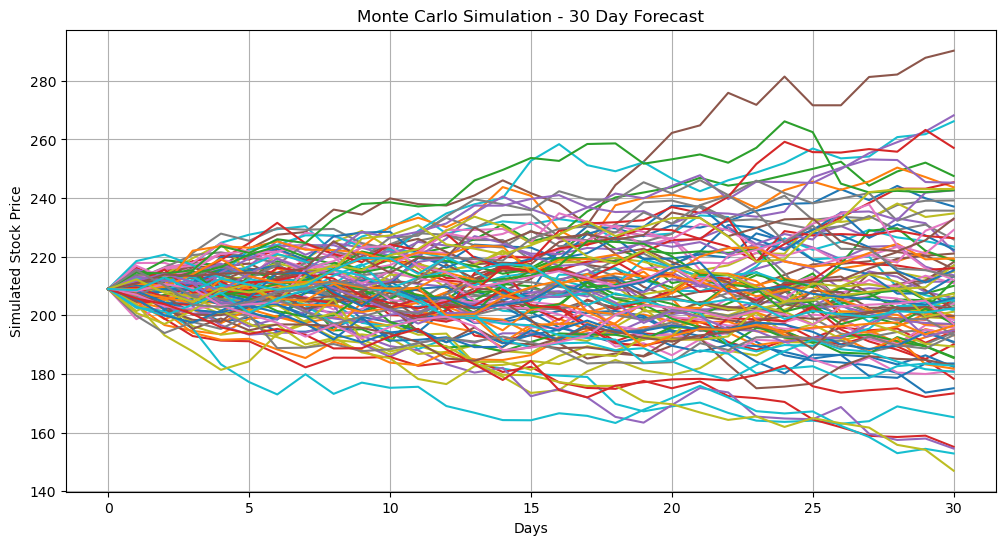

In [14]:

last_price = hist['Close'].iloc[-1]
daily_returns = hist['Close'].pct_change().dropna()
mu = daily_returns.mean()
sigma = daily_returns.std()

num_simulations = 100
num_days = 30

simulations = pd.DataFrame()

for sim in range(num_simulations):
    prices = [last_price]
    for d in range(num_days):
        price = prices[-1] * (1 + np.random.normal(mu, sigma))
        prices.append(price)
    simulations[sim] = prices

simulations.plot(figsize=(12,6), legend=False)
plt.title("Monte Carlo Simulation - 30 Day Forecast")
plt.xlabel("Days")
plt.ylabel("Simulated Stock Price")
plt.grid()
plt.show()


In [15]:
# Mean expected value at Day 30
expected_price = simulations.iloc[-1].mean()

# 95% confidence interval
ci_lower = simulations.iloc[-1].quantile(0.025)
ci_upper = simulations.iloc[-1].quantile(0.975)

print(f"Expected Price in 30 Days: ${expected_price:.2f}")
print(f"95% Confidence Interval: ${ci_lower:.2f} to ${ci_upper:.2f}")


Expected Price in 30 Days: $207.48
95% Confidence Interval: $154.87 to $261.87


## CAPM Calculation

In [31]:
# Download historical data for Apple and S&P 500
aapl = yf.download("AAPL", start="2022-01-01", end="2024-12-31")
sp500 = yf.download("^GSPC", start="2022-01-01", end="2024-12-31")

# Calculate Daily Returns
aapl['Return'] = aapl['Close'].pct_change()
sp500['Return'] = sp500['Close'].pct_change()

# Merge returns into a single DataFrame
returns = pd.concat([aapl['Return'], sp500['Return']], axis=1)
returns.columns = ['AAPL', 'S&P500']
returns.dropna(inplace=True)

# Calculate Beta using linear regression
slope, intercept, r_value, p_value, std_err = linregress(returns['S&P500'], returns['AAPL'])
beta = slope
print(f"Calculated Beta: {beta:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Risk-Free Rate (10-Year US Treasury Yield - approx 4.3%)
rf = 0.043

# Market Return (S&P 500 Avg last 10 years ~ 12%)
rm = 0.12

# CAPM Formula: Cost of Equity
cost_of_equity = rf + beta * (rm - rf)
print(f"Cost of Equity (CAPM): {cost_of_equity:.4f}")

C:\Users\urvis\AppData\Local\Temp\ipykernel_3164\1573434195.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
C:\Users\urvis\AppData\Local\Temp\ipykernel_3164\1573434195.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Calculated Beta: 1.2106
R-squared: 0.6114
Cost of Equity (CAPM): 0.1362


## Simple Moving Average and Exponential Moving Average

C:\Users\urvis\AppData\Local\Temp\ipykernel_3164\2009414896.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download("AAPL", start="2022-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


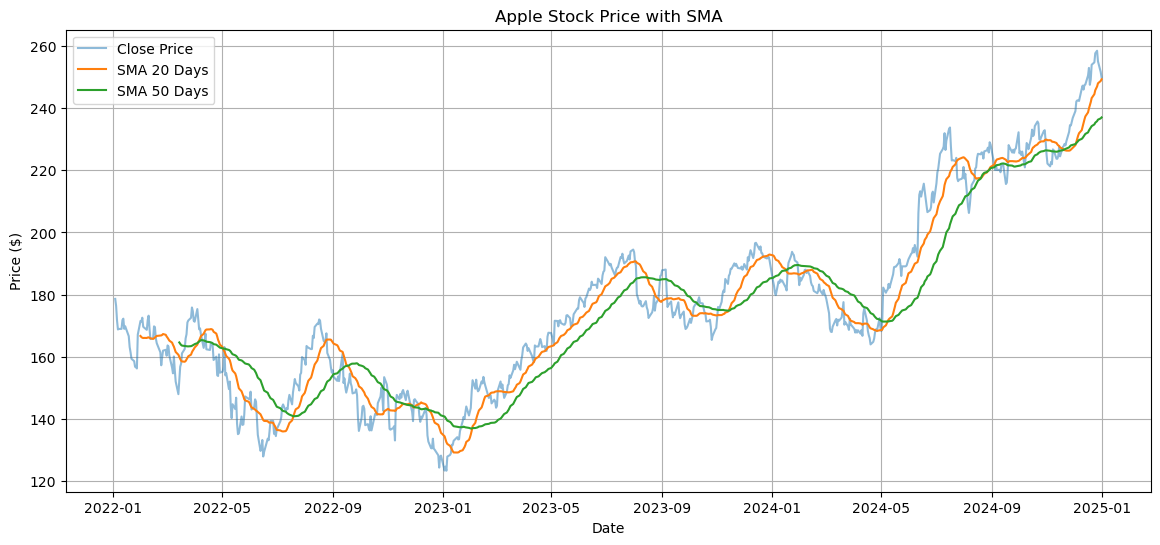

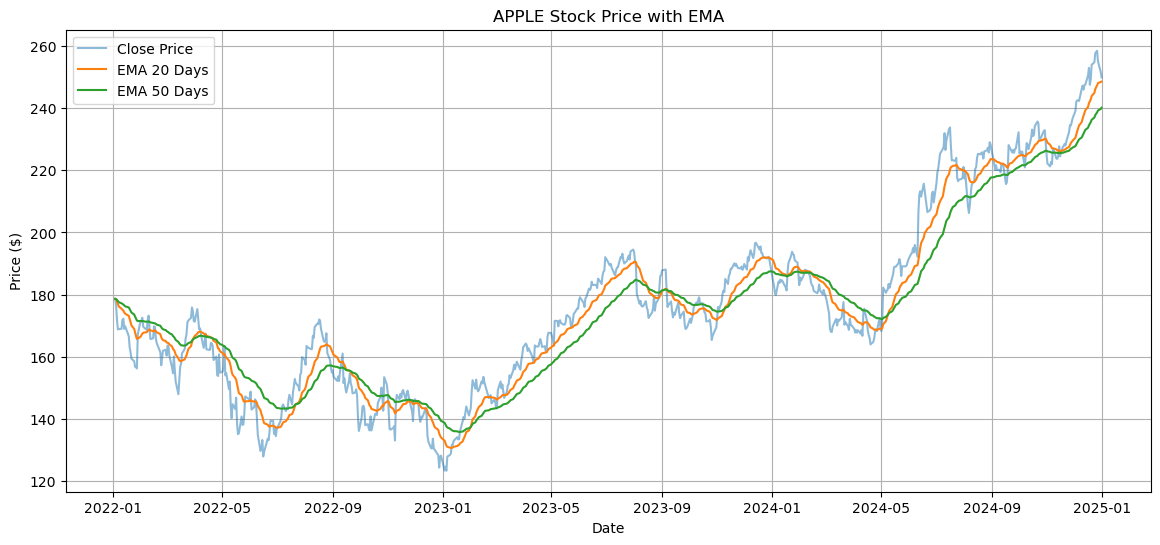

In [18]:

# Download APPLE stock data
aapl = yf.download("AAPL", start="2022-01-01", end="2025-01-01")

# Calculate SMA and EMA
aapl['SMA_20'] = aapl['Close'].rolling(window=20).mean()
aapl['SMA_50'] = aapl['Close'].rolling(window=50).mean()
aapl['EMA_20'] = aapl['Close'].ewm(span=20, adjust=False).mean()
aapl['EMA_50'] = aapl['Close'].ewm(span=50, adjust=False).mean()

#Plot SMA
plt.figure(figsize=(14, 6))
plt.plot(aapl['Close'], label='Close Price', alpha=0.5)
plt.plot(aapl['SMA_20'], label='SMA 20 Days')
plt.plot(aapl['SMA_50'], label='SMA 50 Days')
plt.title("Apple Stock Price with SMA")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Plot EMA
plt.figure(figsize=(14, 6))
plt.plot(aapl['Close'], label='Close Price', alpha=0.5)
plt.plot(aapl['EMA_20'], label='EMA 20 Days')
plt.plot(aapl['EMA_50'], label='EMA 50 Days')
plt.title("APPLE Stock Price with EMA")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

## FB Prophet

In [20]:
# Download Apple historical stock data
aapl = yf.download('AAPL', start='2010-01-01', end='2024-12-31')

# Prepare data in Prophet format
# Access the 'Close' price data using the multi-level index
close_prices = aapl['Close']['AAPL']

# Convert the Series to a DataFrame and rename the column to 'y'
df = close_prices.to_frame(name='y')

# Add the 'Date' index as a column named 'ds' and reset the index
df['ds'] = df.index
df = df.reset_index(drop=True)

# Reorder columns to have 'ds' first
df = df[['ds', 'y']]

# Display last few rows
display(df.tail())

C:\Users\urvis\AppData\Local\Temp\ipykernel_3164\1594704547.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download('AAPL', start='2010-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


ds           y
3768 2024-12-23  254.655716
3769 2024-12-24  257.578674
3770 2024-12-26  258.396667
3771 2024-12-27  254.974930
3772 2024-12-30  251.593094

In [21]:
# Inspect the DataFrame before fitting the model
display(df.info())
display(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3773 non-null   datetime64[ns]
 1   y       3773 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 59.1 KB


None

ds    datetime64[ns]
y            float64
dtype: object

In [22]:
model = Prophet()
model.fit(df)

13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = model.make_future_dataframe(periods=365)
future.tail()

ds
4133 2025-12-26
4134 2025-12-27
4135 2025-12-28
4136 2025-12-29
4137 2025-12-30

In [24]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
4133 2025-12-26  239.303736  226.779108  252.802619
4134 2025-12-27  239.197200  226.410546  252.059059
4135 2025-12-28  239.052911  227.341431  252.043750
4136 2025-12-29  239.098136  225.775901  251.867511
4137 2025-12-30  238.796951  225.529170  252.414605

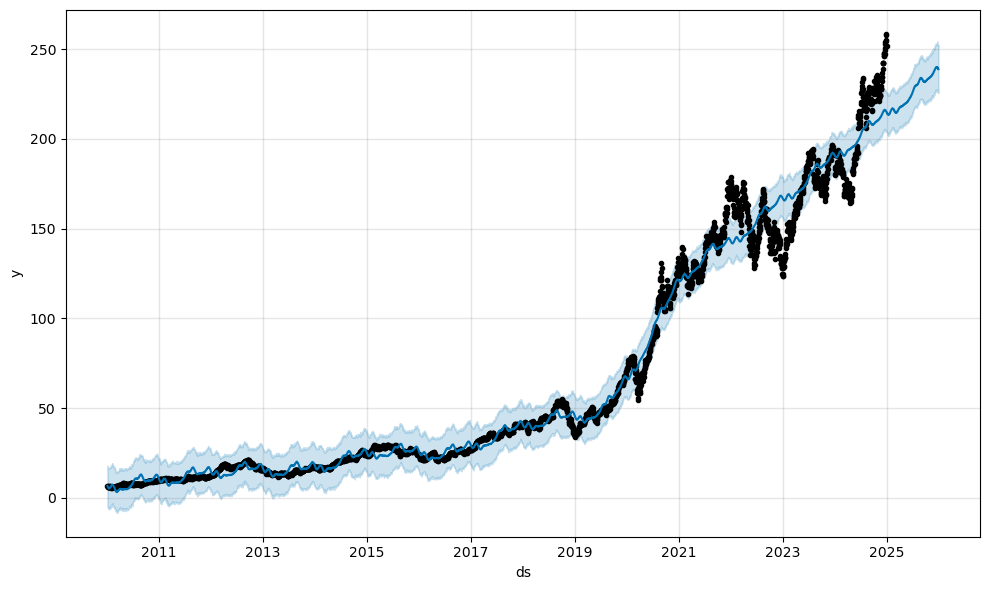

In [25]:
fig1 = model.plot(forecast)

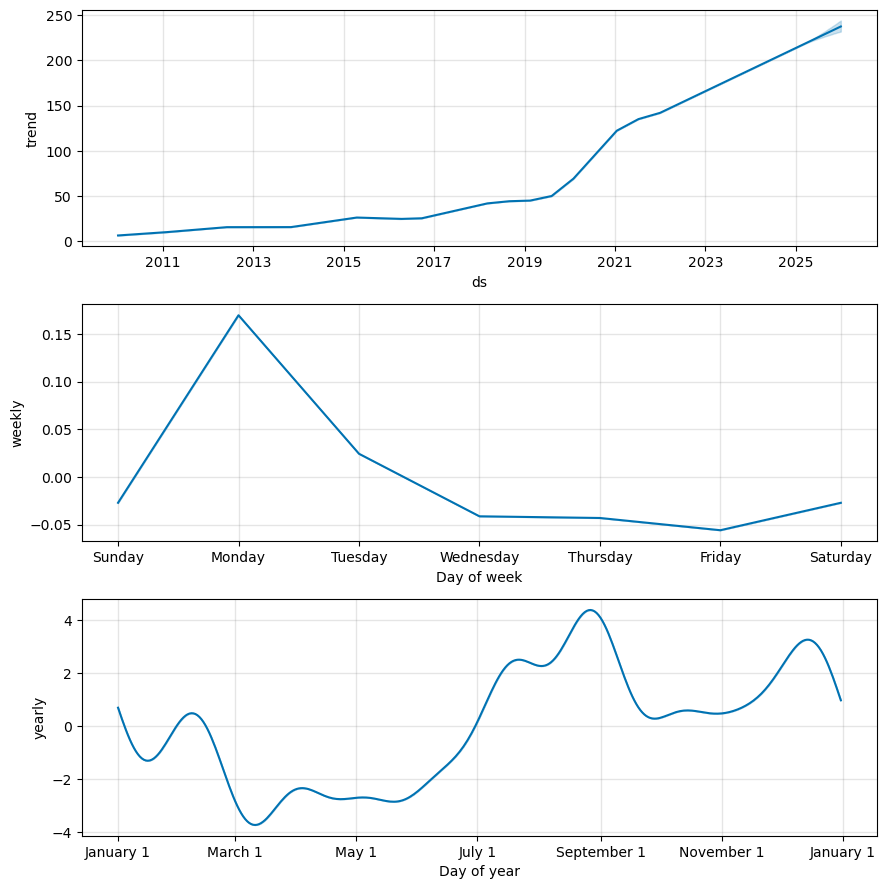

In [26]:
fig2 = model.plot_components(forecast)

In [27]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [28]:
plot_components_plotly(model, forecast)

Cashflow Index Rows:
Index(['Free Cash Flow', 'Repurchase Of Capital Stock', 'Repayment Of Debt',
       'Issuance Of Debt', 'Issuance Of Capital Stock', 'Capital Expenditure',
       'Interest Paid Supplemental Data', 'Income Tax Paid Supplemental Data',
       'End Cash Position', 'Beginning Cash Position', 'Changes In Cash',
       'Financing Cash Flow', 'Cash Flow From Continuing Financing Activities',
       'Net Other Financing Charges', 'Cash Dividends Paid',
       'Common Stock Dividend Paid', 'Net Common Stock Issuance',
       'Common Stock Payments', 'Common Stock Issuance',
       'Net Issuance Payments Of Debt', 'Net Short Term Debt Issuance',
       'Net Long Term Debt Issuance', 'Long Term Debt Payments',
       'Long Term Debt Issuance', 'Investing Cash Flow',
       'Cash Flow From Continuing Investing Activities',
       'Net Other Investing Changes', 'Net Investment Purchase And Sale',
       'Sale Of Investment', 'Purchase Of Investment',
       'Net Business Purch

Free Cash Flow (TTM): 127.7 Billion USD
Firm Value Estimate: 1736.73 Billion USD
Estimated Stock Price: 116.28 USD
